In [1]:
!pip install antropy
import pickle, copy
import numpy as np
import antropy as ent


import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split

C:\Users\NAMRATA\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\NAMRATA\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\NAMRATA\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from scipy.signal import butter, lfilter, sosfilt, sosfreqz, freqz
from sklearn.decomposition import FastICA


In [4]:
deap_dataset_path = "D:/Brain Computer interface/data_preprocessed_python/data_preprocessed_python/s01.dat"
subject_names = ['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 's11', 's12', 
                 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21',
                 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32']


In [5]:
with open (deap_dataset_path,'rb')as f:
    raw_data=pickle.load(f , encoding='latin1')

In [6]:
print(raw_data)

{'labels': array([[7.71, 7.6 , 6.9 , 7.83],
       [8.1 , 7.31, 7.28, 8.47],
       [8.58, 7.54, 9.  , 7.08],
       [4.94, 6.01, 6.12, 8.06],
       [6.96, 3.92, 7.19, 6.05],
       [8.27, 3.92, 7.  , 8.03],
       [7.44, 3.73, 7.08, 7.04],
       [7.32, 2.55, 6.32, 5.87],
       [4.04, 3.29, 3.62, 5.99],
       [1.99, 4.86, 2.04, 7.09],
       [2.99, 2.36, 3.63, 6.24],
       [2.71, 2.77, 3.4 , 7.35],
       [1.95, 3.12, 2.87, 6.18],
       [4.18, 2.24, 3.04, 5.04],
       [3.17, 8.08, 2.91, 5.04],
       [6.81, 7.44, 8.15, 7.14],
       [2.46, 6.91, 6.77, 6.41],
       [7.23, 7.15, 6.94, 8.01],
       [7.17, 8.  , 8.1 , 6.79],
       [8.26, 7.91, 7.19, 8.13],
       [9.  , 7.95, 8.37, 7.86],
       [7.09, 2.08, 7.06, 7.37],
       [8.15, 3.01, 7.37, 7.9 ],
       [7.04, 7.09, 8.01, 8.22],
       [8.86, 7.21, 8.65, 7.21],
       [7.28, 7.27, 7.41, 8.24],
       [7.35, 6.95, 7.03, 7.29],
       [3.88, 3.35, 4.01, 7.87],
       [1.36, 2.27, 3.  , 8.14],
       [2.08, 2.99, 3.22, 7.33],

In [7]:
type(raw_data)

dict

In [8]:
data=raw_data['data']
print(data.shape)

(40, 40, 8064)


In [9]:
labels = raw_data['labels']

In [10]:
print(labels.shape)

(40, 4)


In [13]:
def butter_bandpass(lowcut, highcut, fs, order = 3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order = 5):
    b, a = butter_bandpass(lowcut, highcut, fs, order = order)
    y = lfilter(b, a, data)
    return y
def eye_movement_artifact(shyam): # parameter must be an 2D array like 32_channels*7860_data
    # Inverse that 2D array
    shyam = shyam.transpose()
    ica = FastICA(n_components = 32, random_state = 0, tol = 0.05)
    comps = ica.fit_transform(shyam)
    # invert the array 
    data_after = comps.transpose()
    return data_after
def signal_pro(data):
    fs=128                
    lowcut=0.5
    highcut=45
    # do the bandpass filter
    for i in range(40):
        for j in range(32):
            data[i][j] = butter_bandpass_filter(data[i][j], lowcut, highcut, fs, order=5)
    # creating dummy variable which contains same data information 
    error_eye =  np.zeros((40,32,7680))
    new_data =  np.zeros((40,32,7680))
    for i in range(40):
        for j in range(32):
            for k in range(7680):
                #print(data[i][j][k])
                error_eye[i][j][k] = data[i][j][k]
                new_data[i][j][k] = data[i][j][k]
    for i in range(40):
        error_eye[i] = eye_movement_artifact(error_eye[i])
    for i in range(40):
        for j in range(32):
            mean_value = np.mean(data[i][j])
            for k in range(7680):
                if(data[i][j][k]>0.0): # data is positive
                    if(mean_value>0.0): # error is positive
                        new_data[i][j][k] = data[i][j][k] - mean_value
                    elif(mean_value<0.0): # error is negative
                        new_data[i][j][k] = data[i][j][k] - abs(mean_value)
                elif(data[i][j][k]<0.0): # data is negative
                    if(mean_value>0.0): # error is positive
                        new_data[i][j][k] = data[i][j][k] + mean_value
                    elif(mean_value<0.0): # error is negative
                        new_data[i][j][k] = data[i][j][k] - mean_value
    return new_data

deap = "D:/Brain Computer interface/data_preprocessed_python/data_preprocessed_python/s01.dat"
x = pickle.load(open(deap, "rb"), encoding="latin1")    
labels = x['labels']
data = x['data']
data = data[0:40 , 0:32 , 384:8064]
filter_data = signal_pro(data)
print(np.shape(filter_data))
print(filter_data)

C:\Users\NAMRATA\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\NAMRATA\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(40, 32, 7680)
[[[ 7.95648528e-01  2.89501356e+00  2.61935760e+00 ...  1.39535332e+00
   -3.99159442e+00 -5.33963190e+00]
  [ 5.99469265e-01  2.56429761e+00  3.35377849e+00 ...  3.13934281e+00
   -4.01302308e+00 -7.55416031e+00]
  [ 2.32549631e-01  1.58746963e+00  3.19184223e+00 ...  3.15431765e+00
   -4.35828486e+00 -8.80256423e+00]
  ...
  [ 5.38170240e-01  2.19210252e+00  3.58815943e+00 ...  2.77831240e+00
    7.62529741e+00  7.26733037e+00]
  [ 5.52265355e-01  2.24286773e+00  3.78882258e+00 ... -1.94641285e+00
    3.79207073e+00  7.29873267e+00]
  [ 7.19570848e-01  3.02262303e+00  4.84982576e+00 ... -1.53293283e+00
    3.46835442e+00  3.81903014e+00]]

 [[-8.88176185e-01 -4.95794362e+00 -1.08714171e+01 ...  3.54493852e+00
    8.13599910e+00  8.80617996e+00]
  [-1.24602436e-01 -1.28229620e+00 -4.31482625e+00 ...  4.09423238e+00
    7.43010495e+00  9.32669398e+00]
  [ 2.89096823e-01  5.01637472e-01 -1.52059829e+00 ...  4.51104536e+00
    7.50199258e+00  7.39482773e+00]
  ...
  [ 5.55

In [14]:
print(filter_data.shape)

(40, 32, 7680)


In [15]:
for subject in subject_names:
    
    data = raw_data['data']
    labels = raw_data['labels']
    # we are excluding 3s pre base line i.e. first 3*128 = 384 data points from time series data
    filter_data  = data[0:40, 0:32, 384:8064]
    break

filter_data.shape

(40, 32, 7680)

In [16]:
def petrosian_fd(data, axis=-1):
    # Petrosian fractal dimension
    
    x = np.asarray(data)
    N = x.shape[axis]
    nzc_deriv = ent.num_zerocross(np.diff(x, axis=axis), axis=axis) # Number of sign changes in the first derivative of the signal
    pfd = np.log10(N) / (np.log10(N) + np.log10(N / (N + 0.4 * nzc_deriv)))
    return pfd

In [17]:

window = 1 # fix window size
pfd_features = []
for video_no in range(0, 40):
    for channel_no in range(0, 32):
        input_data = filter_data[video_no][channel_no]
        no_data_in_each_window = int(input_data.shape[0])
        for i in range(window):
            pfd = petrosian_fd(input_data)
            pfd_features.append(pfd)

In [18]:
len(pfd_features)

1280

In [19]:
print(pfd_features)

[1.0154149030532622, 1.0152103914371116, 1.0153362779414403, 1.0157499052047951, 1.0163031035941392, 1.015938013867616, 1.0163603937865302, 1.0187111138570109, 1.0158910089248119, 1.015136908506288, 1.0154463414915795, 1.0174809403497347, 1.015462058225284, 1.0174395878929214, 1.0155982005752007, 1.0144844721371493, 1.015556323856845, 1.0164853143765953, 1.0149162420007065, 1.0150528836143955, 1.0155772636857454, 1.0159641213302237, 1.0154411022121796, 1.0157708178805673, 1.0158335383284438, 1.0172119450447301, 1.0155615590896958, 1.0150633893178453, 1.0161884572545297, 1.0171238993419238, 1.0146109735015392, 1.014273397202759, 1.0160528525670043, 1.0149898338299532, 1.0149582989269696, 1.0187316169785994, 1.0164176620202396, 1.0154987241629776, 1.0160580704096362, 1.018700861246632, 1.0160319793728054, 1.0151998960938364, 1.0151998960938364, 1.0167763903904161, 1.0142469917612325, 1.0155929666283572, 1.0147110442107723, 1.014236428271601, 1.0154987241629776, 1.015979783616402, 1.01424

In [20]:
def emotion_label(labels, class_label):
    em_labels = []
    if(class_label == 'valence'):
        for i in range(0, labels.shape[0]):
            if (labels[i][0]>5): # high valence
                em_labels.append(1)
            else: # low valence
                em_labels.append(0)
        return em_labels
    elif(class_label == 'arousal'):
        for i in range(0, labels.shape[0]):
            if (labels[i][1]>5): # high arousal
                em_labels.append(1)
            else: # low arousal
                em_labels.append(0)
        return em_labels
    elif(class_label == 'all'):
        for i in range(0, labels.shape[0]):
            if (labels[i][0]>5): # high valence
                if(labels[i][1]>5): # high arousal
                    em_labels.append(1) # HVHA
                else:
                    em_labels.append(0) # HVLA
            else: # low valence
                if(labels[i][1]>5): # high arousal
                    em_labels.append(2) # LVHA
                else: # low arousal
                    em_labels.append(3) # LVLA
        return em_labels

In [21]:
type(pfd_features)

list

In [22]:

pfd_m2 = np.array(pfd_features)

In [23]:
type(pfd_m2)

numpy.ndarray

In [24]:
print(pfd_m2.shape)

(1280,)


In [25]:
print(pfd_m2)

[1.0154149  1.01521039 1.01533628 ... 1.01659453 1.01511066 1.01387682]


In [26]:
print(pfd_m2.shape)

(1280,)


# Main

In [211]:
from eeglib.helpers import CSVHelper

helper= CSVHelper("D:/Brain Computer interface/f1.csv")

for eeg in helper:
    print(eeg.PFD().size)

7680


In [212]:
print(eeg.PFD())

[1.05886994 1.0521725  1.0521725  ... 1.05886994 1.05886994 1.04880306]


In [202]:
type(eeg.PFD())

numpy.ndarray

In [30]:
pfd = np.array(eeg.PFD())
pfd = np.reshape(eeg.PFD(), (-1, 32))

In [203]:
print(pfd.shape)

(240, 32)


In [236]:
def emotion_label(labels, class_label):
    em_labels = []
    if(class_label == 'valence'):
        for i in range(0, labels.shape[0]):
            if (labels[i][0]>5): # high valence
                em_labels.append(1)
            else: # low valence
                em_labels.append(0)
        return em_labels
    elif(class_label == 'arousal'):
        for i in range(0, labels.shape[0]):
            if (labels[i][1]>5): # high arousal
                em_labels.append(1)
            else: # low arousal
                em_labels.append(0)
        return em_labels
    elif(class_label == 'all'):
        for i in range(0, labels.shape[0]):
            if (labels[i][0]>5): # high valence
                if(labels[i][1]>5): # high arousal
                    em_labels.append(1) # HVHA
                else:
                    em_labels.append(0) # HVLA
            else: # low valence
                if(labels[i][1]>5): # high arousal
                    em_labels.append(2) # LVHA
                else: # low arousal
                    em_labels.append(3) # LVLA
        return em_labels

In [237]:
print(labels.shape)

(40, 4)


In [ ]:
valence_label = emotion_label(labels, "valence")
y1 = []
for i in range(len(valence_label)):
    for j in range(6):
        y1.append(valence_label[i])
y1 = np.array(y1)
valence_label = y1


# Without FS

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=109)

In [253]:
clf.fit(X_train, y_train)

LinearSVC()

In [254]:
y_predictf = clf.predict(X_test)
print (y_predictf)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0]


In [255]:
#performane evaluation
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_predictf)
print (acc)

0.5833333333333334


In [246]:
print(valence_label)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]


In [247]:
print(y1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]


In [35]:
print(y1.shape)

(240,)


In [36]:
columns_name2 = []
for i in range(32):
    columns_name2.append('ch' + str(i))


df3 = pd.DataFrame(pfd, columns = columns_name2)


tot_features = len(df3.columns)-1
total_features = tot_features

In [37]:
print(total_features)

31


In [38]:
valence_label = emotion_label(labels, "valence")

X = df3


In [39]:
print(df3)

          ch0       ch1       ch2       ch3       ch4       ch5       ch6  \
0    1.058870  1.052173  1.052173  1.048803  1.058870  1.058870  1.068816   
1    1.062198  1.062198  1.052173  1.055528  1.055528  1.062198  1.062198   
2    1.078649  1.068816  1.062198  1.065514  1.062198  1.055528  1.068816   
3    1.065514  1.052173  1.062198  1.068816  1.065514  1.072106  1.058870   
4    1.058870  1.058870  1.058870  1.058870  1.068816  1.068816  1.062198   
..        ...       ...       ...       ...       ...       ...       ...   
235  1.055528  1.062198  1.068816  1.055528  1.045419  1.065514  1.062198   
236  1.058870  1.045419  1.065514  1.065514  1.072106  1.055528  1.055528   
237  1.062198  1.068816  1.078649  1.058870  1.065514  1.065514  1.062198   
238  1.055528  1.058870  1.062198  1.058870  1.062198  1.065514  1.052173   
239  1.075384  1.055528  1.058870  1.068816  1.052173  1.078649  1.075384   

          ch7       ch8       ch9  ...      ch22      ch23      ch24  \
0  

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=109)

In [41]:
print(X)

          ch0       ch1       ch2       ch3       ch4       ch5       ch6  \
0    1.058870  1.052173  1.052173  1.048803  1.058870  1.058870  1.068816   
1    1.062198  1.062198  1.052173  1.055528  1.055528  1.062198  1.062198   
2    1.078649  1.068816  1.062198  1.065514  1.062198  1.055528  1.068816   
3    1.065514  1.052173  1.062198  1.068816  1.065514  1.072106  1.058870   
4    1.058870  1.058870  1.058870  1.058870  1.068816  1.068816  1.062198   
..        ...       ...       ...       ...       ...       ...       ...   
235  1.055528  1.062198  1.068816  1.055528  1.045419  1.065514  1.062198   
236  1.058870  1.045419  1.065514  1.065514  1.072106  1.055528  1.055528   
237  1.062198  1.068816  1.078649  1.058870  1.065514  1.065514  1.062198   
238  1.055528  1.058870  1.062198  1.058870  1.062198  1.065514  1.052173   
239  1.075384  1.055528  1.058870  1.068816  1.052173  1.078649  1.075384   

          ch7       ch8       ch9  ...      ch22      ch23      ch24  \
0  

In [42]:
type(X)

pandas.core.frame.DataFrame

In [43]:
A=np.array(X)

In [44]:
print(X_train.shape)

(192, 32)


In [45]:
type(X_train)

pandas.core.frame.DataFrame

In [46]:
trainingX=np.array(X_train)

In [47]:
type(trainingX)

numpy.ndarray

In [48]:
print(X.shape)

(240, 32)


In [49]:
print(y1.shape)

(240,)


In [50]:
print(y_train.shape)

(192,)


In [51]:
print(y_test.shape)

(48,)


In [52]:
type(y_train)

numpy.ndarray

In [53]:
type(X_test)

pandas.core.frame.DataFrame

In [54]:
testX=np.array(X_test)

In [55]:
print(X_test.shape)

(48, 32)


# Supervised

In [56]:
from skfeature.function.similarity_based import fisher_score

In [57]:
score = fisher_score.fisher_score(trainingX,y_train)

In [58]:
print(score)

[ 5 17 27 16  7 22 26 12 25 19  8 11 15  9 18 28  4 13  2  6  1 24 10 30
 20  0  3 31 14 29 21 23]


In [59]:
idx = fisher_score.fisher_score(trainingX, y_train, mode='rank') 

In [81]:
print(idx)

[ 5 17 27 16  7 22 26 12 25 19  8 11 15  9 18 28  4 13  2  6  1 24 10 30
 20  0  3 31 14 29 21 23]


In [258]:
num_fea = 32


		     
selected_features_train = trainingX[:, idx[0:num_fea]]


		     
selected_features_test = testX[:, idx[0:num_fea]]


		     
print (selected_features_train)



[[1.0521725  1.06219846 1.0521725  ... 1.06219846 1.0521725  1.05552804]
 [1.05552804 1.06219846 1.05886994 ... 1.06551387 1.05886994 1.0521725 ]
 [1.05552804 1.06551387 1.07538381 ... 1.06551387 1.04202136 1.06551387]
 ...
 [1.06881641 1.06219846 1.05552804 ... 1.06219846 1.06219846 1.07210631]
 [1.06219846 1.07210631 1.06881641 ... 1.06551387 1.0521725  1.0521725 ]
 [1.0521725  1.06551387 1.06551387 ... 1.06551387 1.04880306 1.05886994]]


In [259]:
print (selected_features_train.shape)

(192, 32)


In [260]:
print (selected_features_test.shape)

(48, 32)


In [261]:
print (selected_features_test)

[[1.06881641 1.04880306 1.05552804 ... 1.06219846 1.04541944 1.0521725 ]
 [1.06551387 1.06881641 1.06551387 ... 1.07864915 1.06881641 1.06219846]
 [1.06881641 1.06219846 1.05886994 ... 1.05552804 1.05552804 1.06551387]
 ...
 [1.05552804 1.05886994 1.04541944 ... 1.05552804 1.05552804 1.06219846]
 [1.05552804 1.06881641 1.04880306 ... 1.07538381 1.06219846 1.06551387]
 [1.06881641 1.05886994 1.0521725  ... 1.0521725  1.06219846 1.06551387]]


# SVM

In [262]:
from sklearn import svm

clf = svm.LinearSVC()

In [263]:
clf.fit(selected_features_train, y_train)

LinearSVC()

In [267]:
y_predict = clf.predict(selected_features_test)
print (y_predict)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0]


In [271]:
#performane evaluation
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_predict)
print (acc)


0.5833333333333334


In [213]:
clf.fit(trainingX, y_train)

LinearSVC()

In [214]:
y_predict2 = clf.predict(testX)
print (y_predict2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [215]:
#performane evaluation
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_predict2)
print (acc)


0.5833333333333334


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=50)

# Naive Bayes

In [256]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(selected_features_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(selected_features_test)

In [257]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4583333333333333


In [94]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [73]:
 adjusted_mutual_info_score(y_test,y_predict)

-0.011349220735993487

In [95]:
from sklearn.metrics.cluster import davies_bouldin_score

In [100]:
davies_bouldin_score(pfd,y1)

15.576090381163006

In [101]:
davies_bouldin_score(trainingX, y_train)

14.896320038092677

# KNN

In [158]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [159]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [160]:
y_pred = classifier.predict(X_test)

In [162]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
print(ac)

0.5


# Mayfly

In [163]:
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install ReliefF
!pip install -U Py_FS

Requirement already up-to-date: Py_FS in c:\users\namrata\anaconda3\lib\site-packages (0.0.44)


Weight for the classification accuracy [0-1]: 0
Enter the percentage of data wanted for valdiation [0, 100]: 20

                          Iteration - 1


Number of agents: 30

------------- Best Agent ---------------
Fitness: 0.59375
Number of Features: 13
----------------------------------------

Mayfly 1 - Fitness: 0.59375, Number of Features: 13
Mayfly 2 - Fitness: 0.59375, Number of Features: 13
Mayfly 3 - Fitness: 0.59375, Number of Features: 13
Mayfly 4 - Fitness: 0.59375, Number of Features: 13
Mayfly 5 - Fitness: 0.59375, Number of Features: 13
Mayfly 6 - Fitness: 0.59375, Number of Features: 13
Mayfly 7 - Fitness: 0.53125, Number of Features: 15
Mayfly 8 - Fitness: 0.53125, Number of Features: 15
Mayfly 9 - Fitness: 0.53125, Number of Features: 15
Mayfly 10 - Fitness: 0.53125, Number of Features: 15
Mayfly 11 - Fitness: 0.5, Number of Features: 16
Mayfly 12 - Fitness: 0.5, Number of Features: 16
Mayfly 13 - Fitness: 0.5, Number of Features: 16
Mayfly 14 - Fitness: 0.5, Number


Number of agents: 30

------------- Best Agent ---------------
Fitness: 0.53125
Number of Features: 15
----------------------------------------

Mayfly 1 - Fitness: 0.53125, Number of Features: 15
Mayfly 2 - Fitness: 0.53125, Number of Features: 15
Mayfly 3 - Fitness: 0.53125, Number of Features: 15
Mayfly 4 - Fitness: 0.53125, Number of Features: 15
Mayfly 5 - Fitness: 0.53125, Number of Features: 15
Mayfly 6 - Fitness: 0.53125, Number of Features: 15
Mayfly 7 - Fitness: 0.53125, Number of Features: 15
Mayfly 8 - Fitness: 0.53125, Number of Features: 15
Mayfly 9 - Fitness: 0.53125, Number of Features: 15
Mayfly 10 - Fitness: 0.53125, Number of Features: 15
Mayfly 11 - Fitness: 0.53125, Number of Features: 15
Mayfly 12 - Fitness: 0.53125, Number of Features: 15
Mayfly 13 - Fitness: 0.53125, Number of Features: 15
Mayfly 14 - Fitness: 0.53125, Number of Features: 15
Mayfly 15 - Fitness: 0.53125, Number of Features: 15
Mayfly 16 - Fitness: 0.53125, Number of Features: 15
Mayfly 17 - Fit


Number of agents: 30

------------- Best Agent ---------------
Fitness: 0.5
Number of Features: 16
----------------------------------------

Mayfly 1 - Fitness: 0.5, Number of Features: 16
Mayfly 2 - Fitness: 0.5, Number of Features: 16
Mayfly 3 - Fitness: 0.5, Number of Features: 16
Mayfly 4 - Fitness: 0.5, Number of Features: 16
Mayfly 5 - Fitness: 0.5, Number of Features: 16
Mayfly 6 - Fitness: 0.5, Number of Features: 16
Mayfly 7 - Fitness: 0.5, Number of Features: 16
Mayfly 8 - Fitness: 0.5, Number of Features: 16
Mayfly 9 - Fitness: 0.5, Number of Features: 16
Mayfly 10 - Fitness: 0.46875, Number of Features: 17
Mayfly 11 - Fitness: 0.46875, Number of Features: 17
Mayfly 12 - Fitness: 0.46875, Number of Features: 17
Mayfly 13 - Fitness: 0.46875, Number of Features: 17
Mayfly 14 - Fitness: 0.46875, Number of Features: 17
Mayfly 15 - Fitness: 0.46875, Number of Features: 17
Mayfly 16 - Fitness: 0.46875, Number of Features: 17
Mayfly 17 - Fitness: 0.40625, Number of Features: 19
Ma

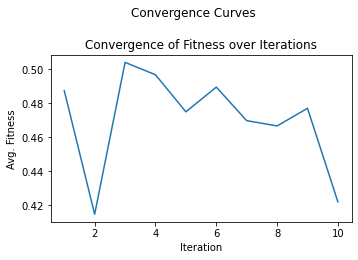

In [164]:
from Py_FS.wrapper.nature_inspired.MA import MA as FS
solution = FS(num_agents=30, max_iter=10, train_data=X, train_label=y1, save_conv_graph=True)

In [165]:
solution.best_agent

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

In [166]:
solution.best_agent.shape

(32,)

In [167]:
solution.best_fitness

0.71875

In [168]:
solution.best_accuracy

0.4166666666666667

In [172]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y1, stratify=y1, test_size=0.2, random_state=2)

In [173]:
type(test_X)

pandas.core.frame.DataFrame

In [174]:
AB = train_X.to_numpy()
CD =test_X.to_numpy()

In [175]:
type(AB)

numpy.ndarray

In [176]:
!pip install tabulate

In [177]:
from tabulate import tabulate
from Py_FS.evaluation.evaluate import evaluate

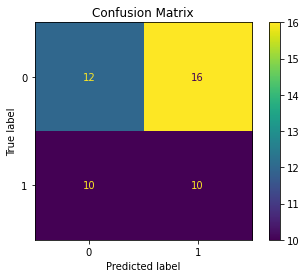

In [178]:
if(len(np.unique(test_Y))) == 2:
  # if it is binary classification, you will get a precision, recall and f1_score for each of the labels
  result = evaluate(AB, CD, y_train, y_test, agent=solution.best_agent, classifier='knn', save_conf_mat=True)
else:  
  # for a multi-class problem, you will get a avreaged precision, recall and f1_score
  # Options for averaging:
  # 1. macro
  # 2. weighted
  # 3. samples
  result = evaluate(AB, CD, y_train, y_test,agent=solution.best_agent, classifier='knn', save_conf_mat=True, averaging="weighted")

In [188]:
result.predictions

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0])

In [187]:
result.accuracy

0.4583333333333333

In [107]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y1, test_size=0.2, random_state=109)


In [108]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(train_X, train_Y)

#Predict the response for test dataset
y_pred = gnb.predict(test_X)

In [109]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5833333333333334


# Unsupervised

In [ ]:
from skfeature.utility import construct_W


		     
kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":5,'t':1}


		     
W = construct_W.construct_W(A, **kwargs_W)

In [4]:
from skfeature.function.similarity_based import lap_score


		     
score = lap_score.lap_score(A, W=W)


		     
print (score)

C:\Users\NAMRATA\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\NAMRATA\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\NAMRATA\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


NameError: name 'A' is not defined

In [3]:
idx = lap_score.lap_score(A,W=W,mode='rank' )

NameError: name 'lap_score' is not defined

In [2]:
print(idx)

NameError: name 'idx' is not defined

In [1]:
num_fea = 3

selected_features = A[:, idx[0:num_fea]]
print(selected_features)



NameError: name 'A' is not defined

In [200]:
from skfeature.utility import unsupervised_evaluation


			 
import numpy as np


			 
num_cluster = len(np.unique(y1))


			 

print (num_cluster)


			 




			 

nmi,acc=unsupervised_evaluation.evaluation(X_selected=selected_features,n_clusters=num_cluster,y1=y)


			 
print (nmi)


			 




			 

print (acc)


			 





2


NameError: name 'y' is not defined